#  <span style="color:green">INFO-F-422-Statistical Foundations of Machine Learning</span>

## <span style="color:green">Zindi: Urban Air Pollution Challenge </span>

## <span style="color:blue">Team members:</span>

- ### VAN CAUWENBERGHE Emile - <emile.van.cauwenberghe@ulb.be> - Student ID ..........
- ### STÜTZLE SANTANGELO Alexander - <Alexander.Stutzle.Santangelo@ulb.be> - Student ID .......
- ### LOUTANI Sara - __[sara.loutani@ulb.be](mailto:sara.loutani@ulb.be) - Student ID 000532123__

## <span style="color:blue">Project presentation:</span>

### www.youtube.com/ !!!!!!!!!!!!!

#  <span style="color:red">I- Case of study </span>

- The Urban Air Pollution Challenge on Zindi focuses on predicting daily **PM2.5** particulate matter concentrations for various cities around the world. **PM2.5** refers to atmospheric particulate matter with a diameter of less than 2.5 micrometers, a primary component of air pollution. High levels of **PM2.5** are associated with severe health risks, including lung cancer, cardiovascular disease, respiratory issues, and metabolic disorders. Accurate predictions of PM2.5 levels can assist governments in their pollution control efforts and help protect vulnerable populations from pollution-related health problems.

### Data :

The dataset for this challenge is derived from the Sentinel-5P satellite and includes various atmospheric measurements relevant to air quality, such as concentrations of ozone, methane, and other pollutants. The data spans from January 2020 to March 2020 and encompasses hundreds of cities globally.
  - <span style="color:red">Train.csv</span>: This file contains the target PM2.5 values and supporting data for 349 locations. It is used to train your predictive model.
  - <span style="color:red">Test.csv</span>:Similar to Train.csv, this file includes data for 179 different locations but does not contain the target PM2.5 values. This is the dataset on which you will apply your trained model to generate predictions.
  - <span style="color:red">SampleSubmission.csv</span>:This file provides the format for submissions, with the 'Place_ID X Date' column corresponding to the Test.csv file and the 'target' column for your predicted PM2.5 values. The order of rows is flexible, but the 'Place_ID X Date' must match precisely.

### Goals of the project :

- The fundamental objective of this project is to develop machine learning models to predict daily PM2.5 concentrations for various cities.
- We will evaluate these models using accuracy and RMSE metrics, selecting the one with the best test accuracy.
- Additionally, we aim to identify which variables in the dataset are the most effective predictors of PM2.5 levels.
- Ultimately, our goal is to support pollution control efforts and protect at-risk populations from the harmful effects of air pollution.

#  <span style="color:red">II- Task 1 </span>

## <span style="color:green">Load required packages :</span>

In [1]:
library(dplyr)
library(randomForest)
library(ggplot2)
library(RSNNS)
library(e1071)
library(xgboost)
library(keras)
library(repr)
library(caret)
library(lubridate)
library(VIM)
library(lightgbm)
library(magick)

options(repr.matrix.max.cols=500, repr.matrix.max.rows=200)
#set.seed(42)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: Rcpp


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:RSNNS’:

    confusionMatrix, train



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions 

#  <span style="color:blue">1. Data processing </span>

## Pipeline :
- This section will contain a few functions that can be called to modify, complete or create new features.

- These Functions can then after be called easilly to try different combinations.

In [2]:
# 2 simple functions that helps getting a clean data easilly for each model, loading data and feature selection :

get_train_data <- function() {
    train_df <- read.csv("Data/Train.csv")
    train_df <- train_df %>% 
        select(-"target_min", -"target_max",-"target_variance",-"target_count")
    return(train_df)
}

In [3]:
get_test_data <- function() {
    train_df <- read.csv("Data/Test.csv")
    return(train_df)
}

## <span style="color:green">Missing values imputation :</span>

Different methods that can be applied to the data in order avoid keeping empty data in the datasets.
1. This method simply deletes all columns containing nan's and keeps only the ones that are complete. This method is quite drastic and reduces a lot our dataset.
2. The second method will tranform all the nan's in the data by the mean of that column. This allows to keep all the original data.
3. The third method will tranform all the nan's in the data by the median of that column. This allows to keep all the original data.
4. The fourth method will tranform all the nan's in the data by the median of that column but grouped for each station. alowing us to keep all the data and also laverage the information of the median of the area.

In [4]:
# Drop na's
drop_na <- function(data) {
    data_clean <- data[, colSums(is.na(data)) == 0]
    return(data_clean)
}

In [5]:
# Replace na's by mean
na_to_mean <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))
    return(data_clean)
}

In [6]:
# Replace na's by median
na_to_median <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), median(., na.rm = TRUE), .)))
    return(data_clean)
}

In [7]:
# Replace NA's by the median by Place_ID
na_to_median_by_location <- function(data) {
    # Step 1: Replace NA's within each Place_ID group
    data_clean <- data %>%
        group_by(Place_ID) %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm = TRUE), .))) %>%
        ungroup()

    # Step 2: Calculate global medians for each numeric column
    global_medians <- data %>%
        summarize(across(where(is.numeric), median, na.rm = TRUE)) %>%
        unlist()
    
    # Step 3: Replace remaining NA's with global medians
    data_clean <- data_clean %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), global_medians[cur_column()], .)))

    return(data_clean)
}



## <span style="color:green">Normalisation :</span>

That function will normalize the whole dataset pet column. (the function scale will also be used later):

In [8]:
#Function that will normalize all the columns
normalize <- function(x) {
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

#  <span style="color:blue">2. Feature engineering </span>

## <span style="color:green">New features creation :</span>

This sections will explain 2 feature engineering techniques that will use the already available data to create more features understandable by the model.
1. the first method is to take the Date feature and divide it into different columns representing the mounth,day of week, the day and also if the day is in the weekend or not. These features can help the model find trends and links between the moment and the target.
2. the second method added is a lag and lead functionality. this will add a new column for each feature giving the previous day feature and the next day's features depending on the number of day's requested. This method increase draticly the number of column has only been used on the final model available in section 3 of the report. This allows the model to get even more context for predicting a write target. This function will replace unavalable data (if previous or future day does not exist) by 0 in order to avoid keeping nan's in the dataset. The image bellow shows an example of how the method i applied

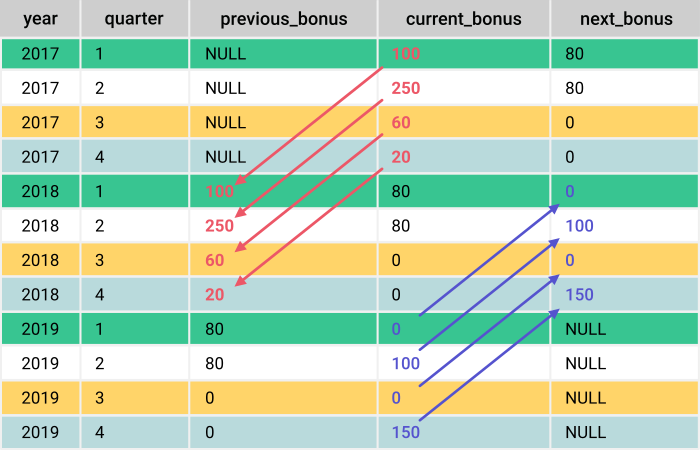

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      700    450 sRGB       TRUE     51044 72x72  


In [9]:
print(image_read("https://learnsql.com/blog/lead-and-lag-functions-in-sql/3.png"))

In [10]:
# Add columns for day, mounth, year, day of the week and if it is weekend or not.
add_time <- function(data) {
    data <- data %>%
        mutate(day = day(Date),
               month = month(Date),
               day_of_week = wday(Date),
               s_weekend = as.integer(wday(Date) %in% c(6, 7)))
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(placeID_freq = n()) %>%
        ungroup()
    return(data)
}

In [11]:
# Function to add lag, lead of all the columns enabeling it to see what was before and after
add_lag_lead <- function(data, days) {
    features <- setdiff(names(data), c("Date", "target_count", "target_min", "Place_ID X Date", "target_variance", "target_max", "Place_ID.X.Date", "target"))
    numeric_features <- sapply(data, is.numeric)
    features <- names(numeric_features[numeric_features == TRUE])
    features <- setdiff(features, c("target", "Place_ID.X.Date", "Date"))
    
    # Wrap operations in a group_by() without arranging
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(across(all_of(features), ~lag(.x, 1), .names = "{.col}_-1"),
               across(all_of(features), ~lead(.x, 1), .names = "{.col}_+1")) %>%
        ungroup()  # Return to regular data frame operation without groups
    
    # Now create the difference features
    if (days>1) {
        for (i in 1:(days-1)) {
            # Creating difference features for lag
            data <- data %>%
                group_by(Place_ID) %>%
                mutate(across(all_of(features), ~. - lag(., i), .names = paste0("{.col}_-", i+1))) %>%
                ungroup()
            
            # Creating difference features for lead
            data <- data %>%
                group_by(Place_ID) %>%
                mutate(across(all_of(features), ~. - lead(., i), .names = paste0("{.col}_+", i+1))) %>%
                ungroup()
        }
    }
    
    # Replace NA values in numeric columns with 0
    numeric_columns <- sapply(data, is.numeric)
    data[numeric_columns] <- lapply(data[numeric_columns], function(x) replace(x, is.na(x), 0))
    
    return(data)
}


## <span style="color:green">Divide train / validation set :</span>

The following functions will split the training data into training and validation data. this allows to separate the training set from the validation set and avoids the model to overfit the predictions.
1. The first function will seperate the data by also keeping the Place_ID's together. this is because the test data has no Place_ID in commun with the training data. it was therefore logic to seperate them during the trainging and validation data.
2. The second function is a simple train/val seperating function.

After some test we tought the results comming from the first function would give better results beceause it would avoid overfitting but when applied on the real data we found out the second function had better results. This is why in the next parts of the code we will mostly use the second function.

In [12]:
# randomise stations in train and val by grouping the Place_ID's
# This allows to not overfit with the test data that doesn't contain similar Place_ID's as the training data.
get_train_val_by_station <- function(data,rep) {
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    num_train <- round(length(shuffled_place_ids) * rep)
    train_ids <- shuffled_place_ids[1:num_train]
    val_ids <- shuffled_place_ids[(num_train + 1):length(shuffled_place_ids)]
    train <- data[data$Place_ID %in% train_ids, ] %>% 
      select(-"Place_ID")
    val <- data[data$Place_ID %in% val_ids, ] %>% 
      select(-"Place_ID")
    return(list(train = train, val = val))
}

# Unfortunatly this method when applied seemed to give worse results compared to the normal random division.
# This is why in the next steps only the normal random division will be used.

In [13]:
# Random attiribution of each line to train or val. this will give us a bigger difference between the val score and the test 
# score beceause no station will be in commun.
get_train_val <- function(data, rep) {
    shuffled_indices <- sample(nrow(data))
    num_train <- round(nrow(data) * rep)
    train_indices <- shuffled_indices[1:num_train]
    val_indices <- shuffled_indices[(num_train + 1):nrow(data)]
    train <- data[train_indices, ] %>% 
      select(-"Place_ID")
    val <- data[val_indices, ] %>% 
      select(-"Place_ID")
    return(list(train = train, val = val))
}

## <span style="color:green">Configuration grid example :</span>

This allows to decide for each test which missing value imputation, normalization, feature engeneering and train_val repartition to use

In [41]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
# data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID X Date","Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

## <span style="color:green">Plot repartition of the data :</span>

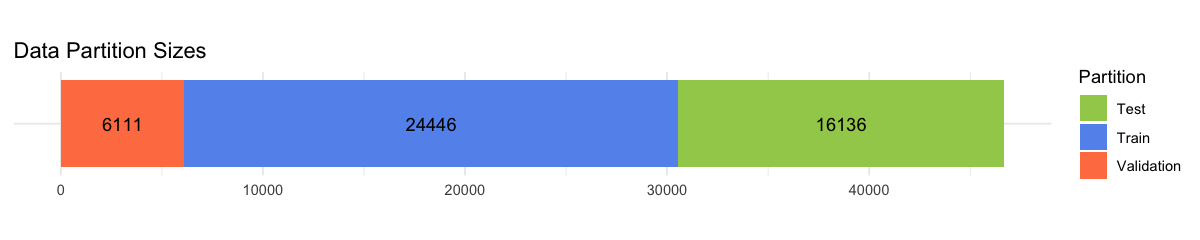

In [99]:
partition_sizes <- data.frame(
  Partition = c("Train", "Validation", "Test"),
  Size = c(nrow(data_train_val$train), nrow(data_train_val$val), nrow(test_data))
)

# Plot the partition sizes
options(repr.plot.width = 10, repr.plot.height = 2)
ggplot(partition_sizes, aes(x = "", y = Size, fill = Partition)) +
  geom_bar(stat = "identity", width = 1) +
  coord_flip() +
  geom_text(aes(label = Size), position = position_stack(vjust = 0.5)) +
  theme_minimal() +
  labs(title = "Data Partition Sizes", x = NULL, y = NULL) +
  scale_fill_manual(values = c("Train" = "cornflowerblue", "Validation" = "coral", "Test" = "darkolivegreen3")) +
  theme(
    axis.ticks = element_blank(), 
    axis.text.y = element_blank(),
    aspect.ratio = 1/10 # Adjust the aspect ratio to make the plot shorter
  )

The repartition is done based on the given data and also the recommended train-val split in the course and found looking online (which is 80% training and 20% validation)


#  <span style="color:red">Task 2 : Model selection </span>


## <span style="color:blue">Data preparation for all models </span>

In [14]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(where(is.numeric), median, na.rm =
  TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of
  dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous
function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


In [17]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target
val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target
# Normalize the features (if necessary)
train_x_norm <- scale(train_x)
val_x_norm <- scale(val_x)


# <span style="color:green">1. Neural Network :</span>

In [24]:
create_nn_model <- function(input_shape) {
  nn_model <- keras_model_sequential() %>%
    layer_dense(units = 16, activation = 'relu', input_shape = input_shape) %>%
    layer_dense(units = 8, activation = 'relu') %>%
    layer_dense(units = 16, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    layer_dense(units = 1)
  
  nn_model %>% compile(
    loss = 'mse',  # Mean Squared Error for regression
    optimizer = 'adam',  # Adaptive moment estimation
    metrics = c('mean_absolute_error')
  )
  
  return(nn_model)
}

# Create the model
input_shape <- ncol(train_x)
model <- create_nn_model(input_shape)

# Train the model
history <- model %>% fit(
  train_x_norm, train_y,
  epochs = 1000,
  batch_size = 32,
  validation_split = 0.2
)

# Make predictions on the validation data
predictions <- model %>% predict(val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_nn = rmse
print(paste("RMSE: ", rmse))

[1] "RMSE:  34.6742441529574"


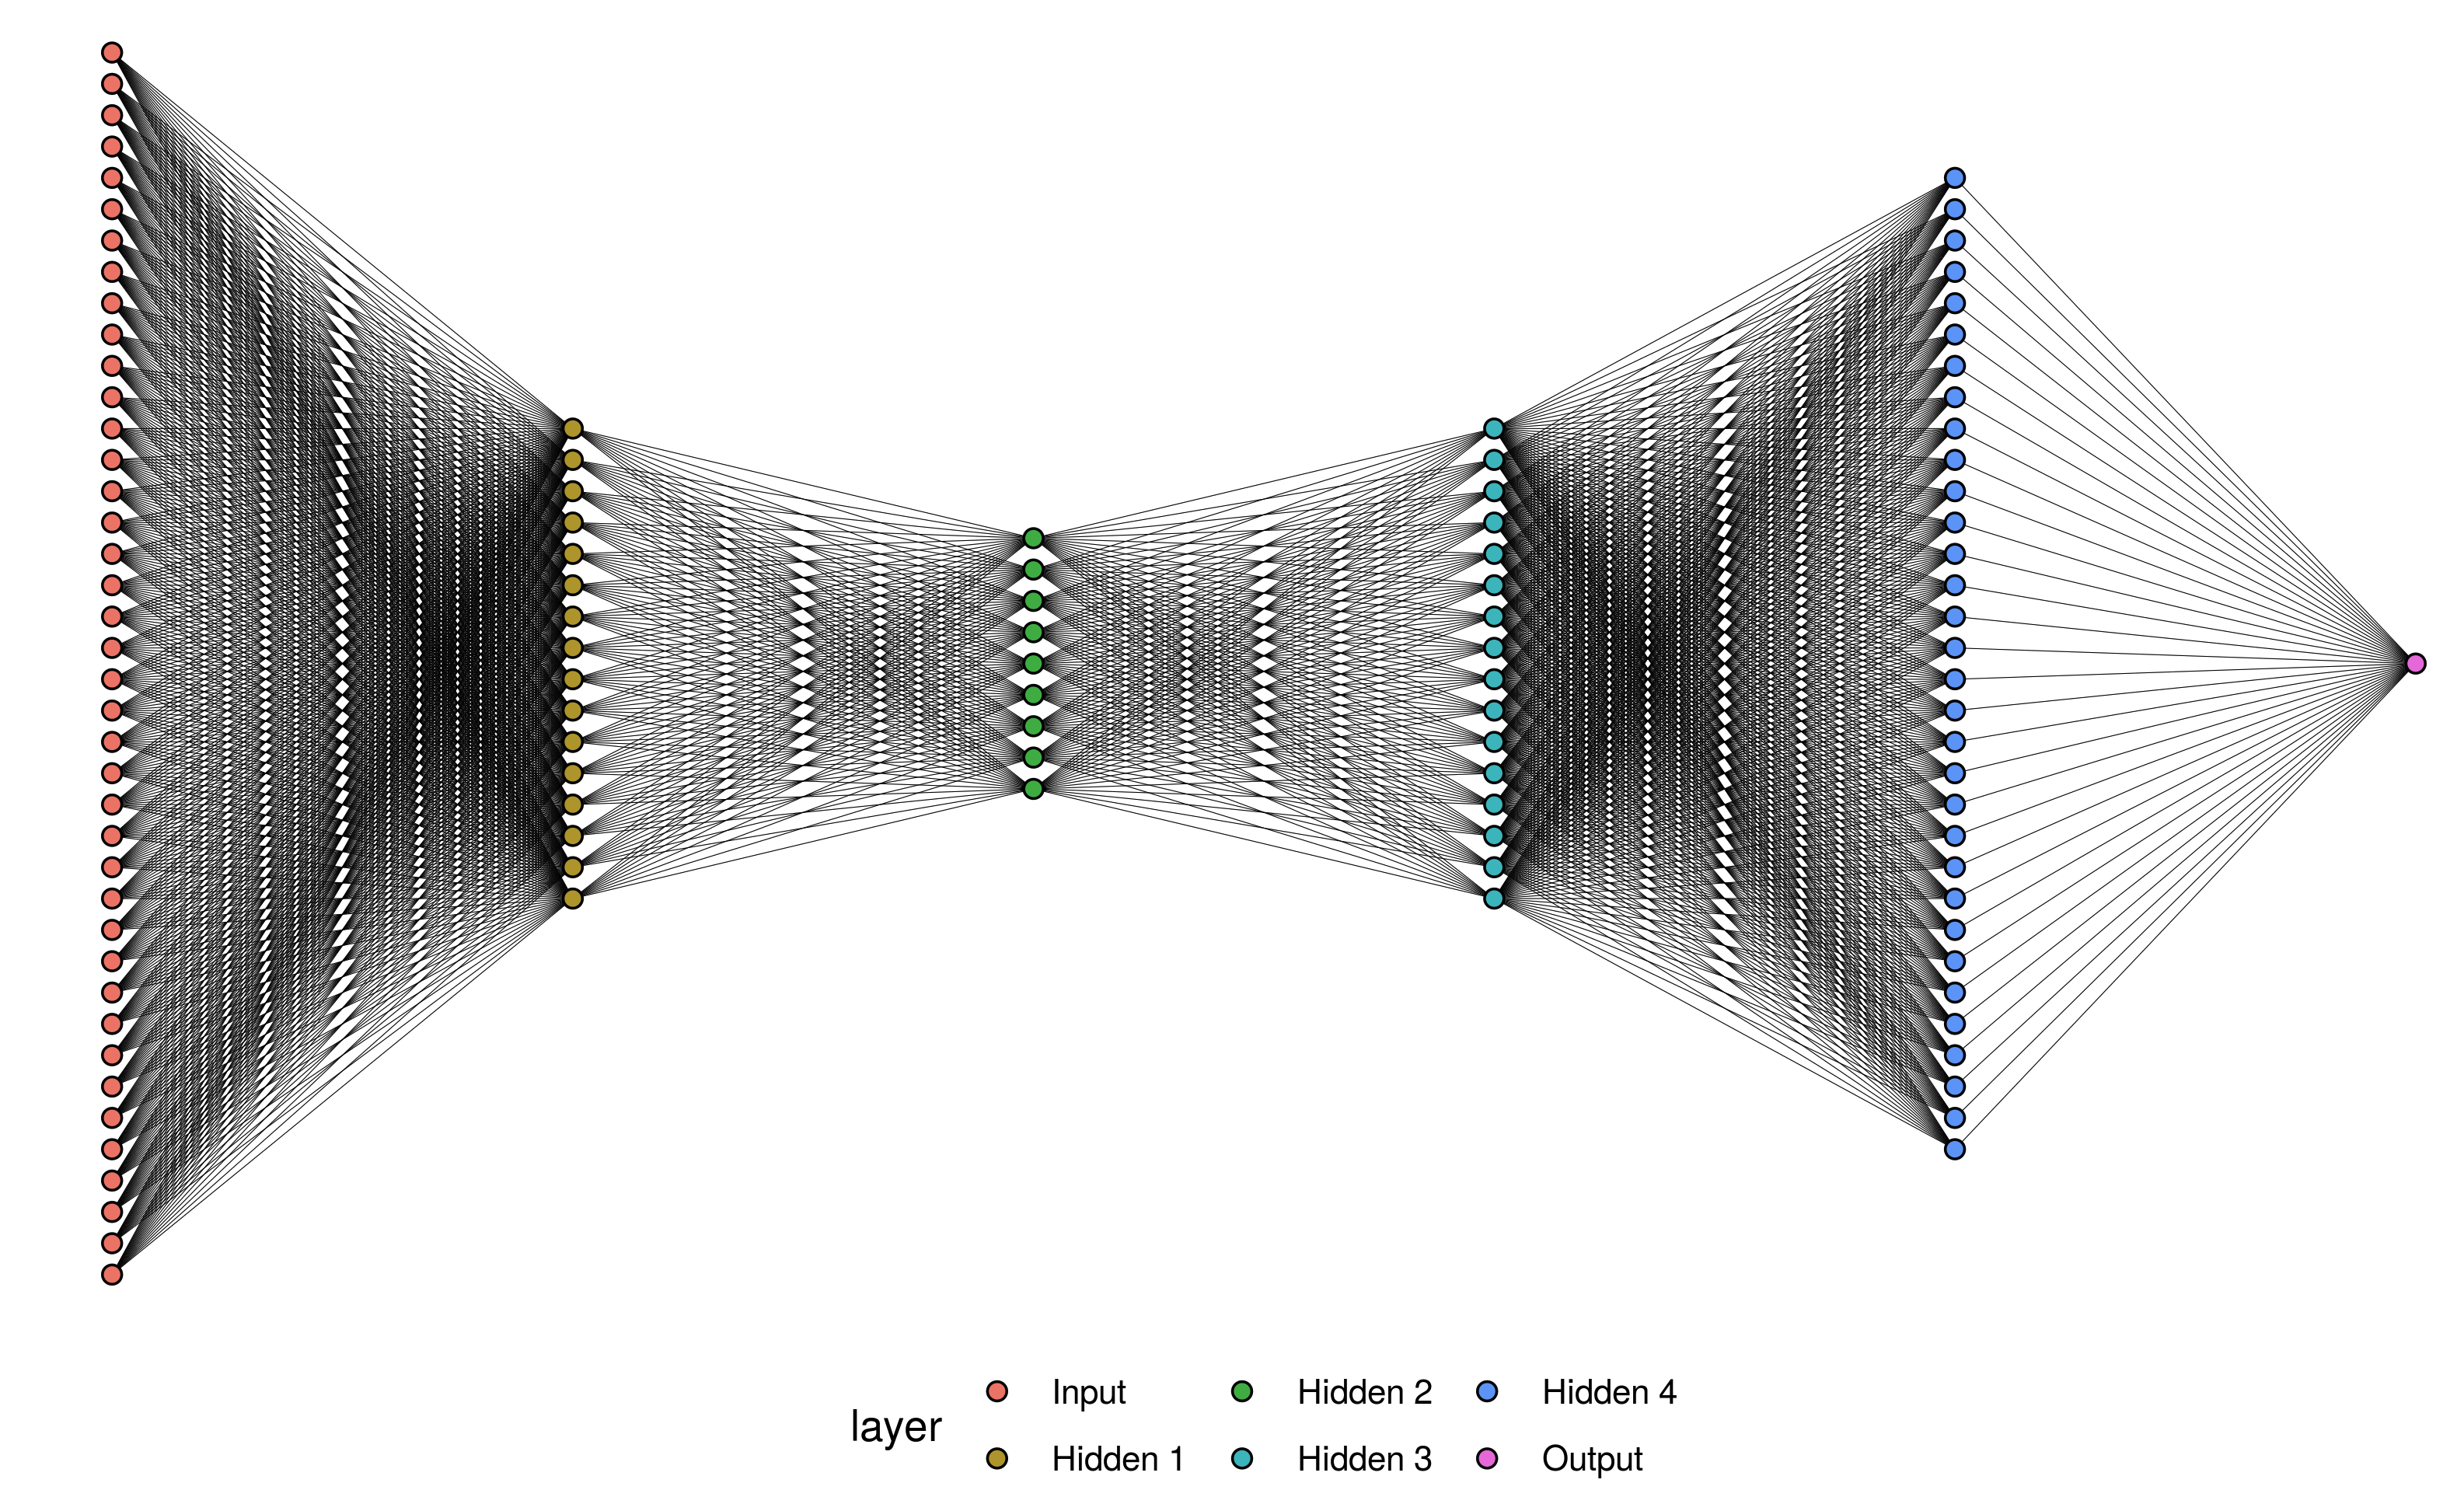

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     3170   1926 sRGB       TRUE   2584816 57x57  


In [25]:
img <- image_read("images//Screenshot 2024-05-17 at 13.54.38.png")  

# Display the image
print(img)

# <span style="color:green">2. RSNNS :</span>


In [19]:
control <- trainControl(method = "none")
RSNNS_model <- train(train_x_norm, train_y, method = "mlp", trControl = control)

In [20]:
predictions <- predict(RSNNS_model, val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_rsnns = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 48.453524405078"



# <span style="color:green">3. SVM :</span>

In [21]:
svm_model <- svm(target ~ ., data = data_train_val$train)

In [22]:
predictions <- predict(svm_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_svm = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 30.0327501465375"



# <span style="color:green">4. Random Forest :</span>

In [23]:
rf_model <- randomForest(target ~ ., data = data_train_val$train)

In [24]:
predictions <- predict(rf_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_rf = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 29.8543996344159"



## <span style="color:orange"> Models comparaison </span>

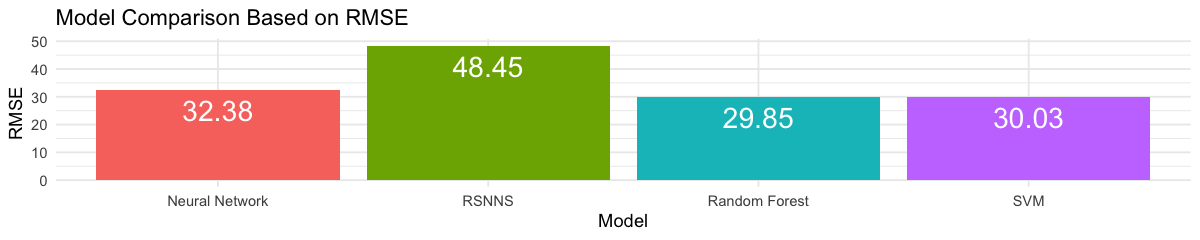

In [62]:
# Create a dataframe with RMSE values
rmse_df <- data.frame(
  Model = c("Neural Network", "RSNNS", "SVM", "Random Forest"),
  RMSE = c(score_nn, score_rsnns, score_svm, score_rf))

# Plot RMSE values
ggplot(rmse_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(RMSE, 2)), vjust = 1.5, color = "white", size = 6) +
  theme_minimal() +
  ggtitle("Model Comparison Based on RMSE")+
  theme(legend.position = "none")


#  <span style="color:red">Task 3 : Other models implementations </span>




# <span style="color:blue">1. XGBoot :</span>


## <span style="color:green">Input configuration :</span>

In [26]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [27]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
#train_x_norm <- scale(train_x)
#val_x_norm <- scale(val_x)


## <span style="color:green">Implementation :</span>

In [28]:
train_x_matrix <- as.matrix(train_x)
train_y_vector <- as.numeric(train_y)
dtrain <- xgb.DMatrix(data = train_x, label = train_y)

xgb_model <- xgb.train( data = dtrain, nrounds = 50)

In [29]:
dval <- xgb.DMatrix(data = val_x)
predictions <- predict(xgb_model, dval)
rmse <- sqrt(mean((predictions - val_y)^2))
score_xgb = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 33.2578646728697"



# <span style="color:blue">2. LGB model :</span>


## <span style="color:green">Input configuration :</span>


In [55]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
data <- add_lag_lead(data,2)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

[1] 1


In [100]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
#train_x_norm <- scale(train_x)
#val_x_norm <- scale(val_x)


## <span style="color:green">Implementation basic model:</span>

In [101]:
dtrain <- lgb.Dataset(data = train_x, label = train_y)#, free_raw_data = FALSE)
dtest <- lgb.Dataset(data = val_x, label = val_y)#, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse")

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435208
[LightGBM] [Info] Number of data points in the train set: 24446, number of used features: 1797
[LightGBM] [Info] Start training from score 61.120825


In [102]:
predictions <- predict(lgb_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_lgb_basic = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 25.9192455060904"



## <span style="color:green">Implementation finetuned model:</span>

In [103]:
dtrain <- lgb.Dataset(data = train_x, label = train_y, free_raw_data = FALSE)
dtest <- lgb.Dataset(data = val_x, label = val_y, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse",
    force_col_wise = TRUE,
    num_leaves = 50,
    max_depth = -1,
    min_data_in_bin = 50
)

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain,
  nrounds = 200,  # Use nrounds instead of num_boost_round
  early_stopping_rounds = 10,
  valids = list(test = dtest),  # Use valids instead of valid_sets
  verbose = 1500  # Use verbose instead of verbose_eval
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.798559
[LightGBM] [Info] Total Bins 410015
[LightGBM] [Info] Number of data points in the train set: 24446, number of used features: 1797
[LightGBM] [Info] Start training from score 61.120825
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[1]:  test's rmse:44.4292 
Will train until there is no improvement in 10 rounds.
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[2]:  test's rmse:42.5805 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[3]:  test's rmse:40.9783 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[4]:  test's rmse:39.5323 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[5]:  test's rmse:38.2508 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[6]:  test's rmse:37.163 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[7]:  test's rmse:36.1741 
[LightGBM] [Debug] Trained a tre

#### <span style="color:green"> Predictions:</span>

In [104]:
predictions <- predict(lgb_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_lgb_basic = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 24.5889087447468"



## <span style="color:orange"> Models comparaison </span>

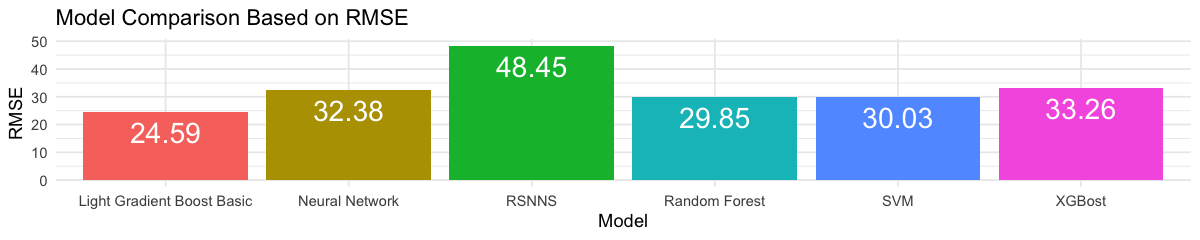

In [105]:
# Create a dataframe with RMSE values
rmse_df <- data.frame(
  Model = c("Neural Network", "RSNNS", "SVM", "Random Forest", "XGBost", "Light Gradient Boost Basic"),
  RMSE = c(score_nn, score_rsnns, score_svm, score_rf, score_xgb, score_lgb_basic))

# Plot RMSE values
ggplot(rmse_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(RMSE, 2)), vjust = 1.5, color = "white", size = 6) +
  theme_minimal() +
  ggtitle("Model Comparison Based on RMSE")+
  theme(legend.position = "none")


## <span style="color:green">Training model on the complete dataset:</span>

In [32]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date","Place_ID"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]

In [33]:
train_x <- train_data %>% select(-c(target)) %>% as.matrix()
train_y <- train_data$target

In [34]:
dtrain <- lgb.Dataset(data = train_x, label = train_y, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse",
    force_col_wise = TRUE,
    num_leaves = 50,
    max_depth = -1,
    min_data_in_bin = 50
)

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain)

[LightGBM] [Info] Total Bins 414161
[LightGBM] [Info] Number of data points in the train set: 30557, number of used features: 1797
[LightGBM] [Info] Start training from score 61.148045



#  <span style="color:red">Task 4 : Zindi competition submition </span>

In [36]:
test_data <- as.data.frame(test_data)
test_x <- as.matrix(select(test_data, -target))
predictions <- predict(lgb_model, test_x)
# predictions <- round(predictions) # Option to round the predictions
predictions_df <- data.frame(
  "Place_ID X Date" = tail(data,length(predictions))$Place_ID.X.Date,
  target = predictions
)

if (all(dim(predictions_df) == c(16136, 2))) {
    write.csv(predictions_df, "predictions.csv", row.names = FALSE)
    print("File Saved")
} else {
  print("Output format is not correct")
}

[1] "File Saved"


The results obtained using the final LGB model were uploaded on Zindi and gave us a RMSD of 31.62746413. a quite good result placing us in the position 75 of the competition.


#  <span style="color:red">Task 3 : Ranking the 10 th most predictive features </span>

## Further implementations to increase the score